# Přísnost známkování na PISA 2018

Odhadni model ve Statě, následně spočítej rezidua v Pythonu a použij je k analýze.

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [87]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [88]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [89]:
stu18_meta.variable_value_labels['ST001D01T']

{7.0: 'Grade 7',
 8.0: 'Grade 8',
 9.0: 'Grade 9',
 10.0: 'Grade 10',
 11.0: 'Grade 11',
 12.0: 'Grade 12',
 13.0: 'Grade 13',
 96.0: 'Ungraded',
 97.0: 'Not Applicable',
 98.0: 'Invalid',
 99.0: 'Missing'}

In [90]:
stu18_meta.variable_value_labels['STRATUMID_rec']

{1.0: 'ZŠ',
 2.0: 'VG',
 3.0: 'G4',
 4.0: 'SOŠ s mat.',
 5.0: 'SOU bez mat.',
 6.0: 'spec.'}

In [91]:
df = stu18[(stu18['ST001D01T'] == 9) & (stu18['STRATUMID_rec'] == 1) & (np.isfinite(stu18['ST800C01HA_CZ'])) & (stu18['ST800C01HA_CZ'] <= 5)].copy()

In [92]:
df.shape

(1881, 724)

In [93]:
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)

In [94]:
df['gr_matematika'] = np.where(df['ST800C01HA_CZ'] < 3, df['ST800C01HA_CZ'], np.where(df['ST800C01HA_CZ'] < 6, 8 - df['ST800C01HA_CZ'], np.nan))
df['girl'] = np.int_(df['ST004D01T'] == 1)

```
-------------------------------------------------------------------------------
         math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
--------------+----------------------------------------------------------------
gr_matematika |  -40.42968   1.974654   -20.47   0.000    -44.36313   -36.49622
         girl |  -20.67295   4.584914    -4.51   0.000    -29.94105   -11.40486
        _cons |   588.2976   7.345191    80.09   0.000     573.8064    602.7888
-------------------------------------------------------------------------------
```

In [96]:
df['MATH_PRED'] = 588.2976 - 20.67295 * df['girl'] - 40.42968 * df['gr_matematika']

In [97]:
df['MATH_RESID'] = df['MATH_MEAN'] - df['MATH_PRED']

In [98]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [99]:
sch_resid = df.groupby('CNTSCHID')[['MATH_RESID', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')

In [100]:
sch_wr = pd.merge(sch18[['CNTSCHID', 'W_SCHGRNRABWT']], sch_resid.rename(columns={'MATH_RESID': 'MATH_SCHOOL_RESID'}).reset_index())

In [101]:
dsw = DescrStatsW(sch_wr['MATH_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])

In [102]:
qs = dsw.quantile([0.2, 0.4, 0.6, 0.8])

In [103]:
qs

p
0.2   -27.037294
0.4    -6.565673
0.6    10.682785
0.8    27.987659
dtype: float64

In [104]:
sch_wr['SCH_BIN'] = pd.cut(sch_wr['MATH_SCHOOL_RESID'], [-np.inf] + list(qs) + [np.inf], labels=False)

In [105]:
sch_wr

,CNTSCHID,W_SCHGRNRABWT,MATH_SCHOOL_RESID,SCH_BIN
0,20300002.0,24.29682,4.281343,2
1,20300005.0,26.19107,4.366911,2
2,20300006.0,21.93036,-34.337844,0
3,20300010.0,22.01021,1.026490,2
4,20300018.0,15.37976,16.770075,3
...,...,...,...,...
123,20300322.0,12.42679,-65.051562,0
124,20300323.0,13.33673,32.622174,4
125,20300326.0,9.97579,-8.274480,1
126,20300329.0,13.34809,28.695111,4


In [106]:
df = pd.merge(df, sch_wr)

In [108]:
df.head()

,CNTSTUID,CNTSCHID,CNTRYID,STRATUM,STRATUMID_rec,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,...,ST802C03HA_CZ,ST803C01HA_CZ,MATH_MEAN,gr_matematika,girl,MATH_PRED,MATH_RESID,W_SCHGRNRABWT,MATH_SCHOOL_RESID,SCH_BIN
0,20300004.0,20300080.0,203.0,CZE0707,1.0,9.0,9.0,2002.0,2.0,4.0,...,NaN,2.0,383.7898,2.0,0,507.43824,-123.64844,22.01021,-25.839824,1
1,20300148.0,20300080.0,203.0,CZE0707,1.0,9.0,11.0,2002.0,2.0,1.0,...,1.0,1.0,505.2687,2.0,0,507.43824,-2.16954,22.01021,-25.839824,1
2,20300277.0,20300080.0,203.0,CZE0707,1.0,9.0,10.0,2002.0,2.0,2.0,...,1.0,2.0,537.5343,1.0,0,547.86792,-10.33362,22.01021,-25.839824,1
3,20300863.0,20300080.0,203.0,CZE0707,1.0,9.0,8.0,2002.0,1.0,1.0,...,1.0,4.0,433.9740,3.0,1,446.33561,-12.36161,22.01021,-25.839824,1
4,20301142.0,20300080.0,203.0,CZE0707,1.0,9.0,2.0,2002.0,2.0,2.0,...,1.0,1.0,456.2012,2.0,0,507.43824,-51.23704,22.01021,-25.839824,1


In [109]:
foo = df.groupby(['SCH_BIN', 'gr_matematika'])[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()

In [110]:
foo

,SCH_BIN,gr_matematika,MATH_MEAN
0,0,1.0,476.422674
1,0,2.0,455.243325
2,0,3.0,401.087354
3,0,4.0,380.090725
4,0,5.0,325.182870
5,1,1.0,526.220306
6,1,2.0,481.159231
7,1,3.0,436.736941
8,1,4.0,403.369207
9,1,5.0,400.280659


<AxesSubplot:xlabel='gr_matematika', ylabel='MATH_MEAN'>

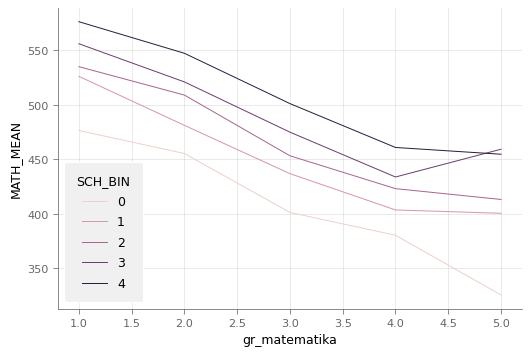

In [111]:
sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='SCH_BIN')

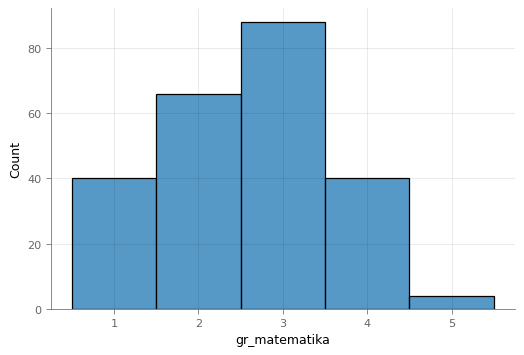

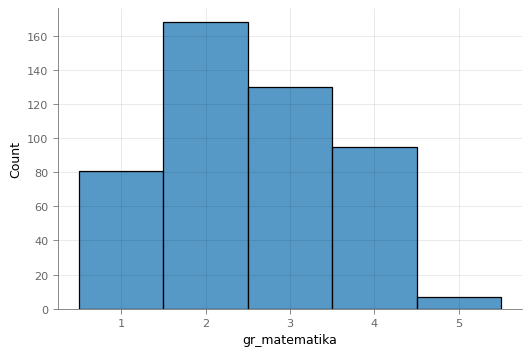

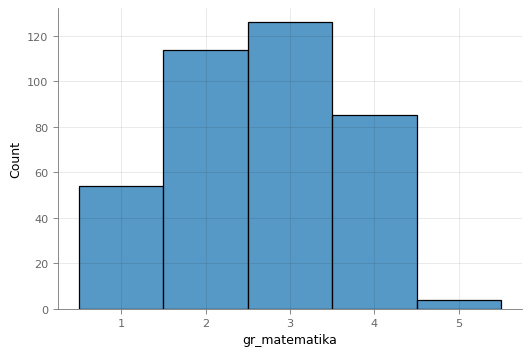

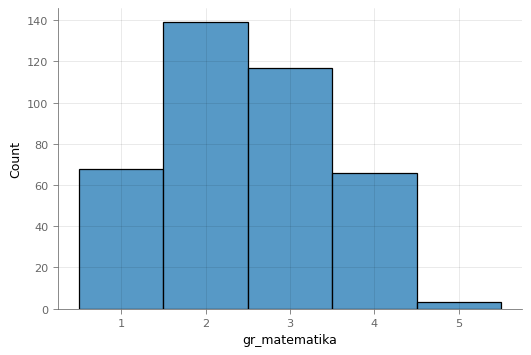

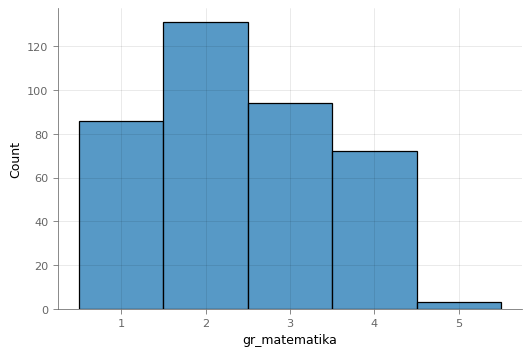

In [115]:
for i in range(5):
    plt.subplots()
    sns.histplot(x='gr_matematika', data=df[df['SCH_BIN'] == i], discrete=True)

In [ ]:
# můžu změnit dataset na long a vykreslit všechny plausible values včetně nejistoty?

In [116]:
for i in range(1, 11):
    df[f'math_score_{i}'] = df[f'PV{i}MATH']

In [118]:
dfl = pd.wide_to_long(df, 'math_score', sep='_', j='pv', i=['CNTSTUID'])

In [120]:
dfl.head()

,,ST207Q04HA,IC014Q06NA,ST008Q02TA,ST012Q01TA,IC001Q07TA,W_FSTURWT55,PV6MATH,MISCED_D,IC008Q07NA,SCREADDIFF,...,W_FSTURWT4,ST800C04HA_CZ,CULTPOSS,ST205Q02HA,ST153Q06HA,ST019BC01T_CZ,PV1GLCM,AGE,PV3SCIE,math_score
CNTSTUID,pv,,,,,,,,,,,,,,,,,,,,,
20300004.0,1,2.0,4.0,NaN,2.0,1.0,6.44664,339.360,1.0,3.0,0.7950,...,37.57377,2.0,-1.1478,2.0,1.0,2.0,NaN,15.58,417.446,400.912
20300148.0,1,4.0,3.0,2.0,3.0,1.0,6.44664,491.041,4.0,1.0,0.4090,...,37.57377,2.0,-1.0005,3.0,2.0,1.0,NaN,15.42,500.451,511.288
20300277.0,1,2.0,4.0,NaN,4.0,1.0,6.44664,536.153,3.0,4.0,-1.0064,...,37.57377,1.0,-1.1478,3.0,2.0,1.0,NaN,15.50,539.038,554.828
20300863.0,1,3.0,2.0,2.0,3.0,1.0,6.60680,458.356,4.0,1.0,-0.0362,...,42.33686,2.0,-0.1884,1.0,1.0,1.0,NaN,15.67,428.272,438.824
20301142.0,1,3.0,3.0,2.0,4.0,1.0,6.44664,380.544,3.0,5.0,0.8812,...,37.57377,2.0,-1.8944,3.0,2.0,7.0,NaN,16.17,418.132,483.955


<AxesSubplot:xlabel='gr_matematika', ylabel='math_score'>

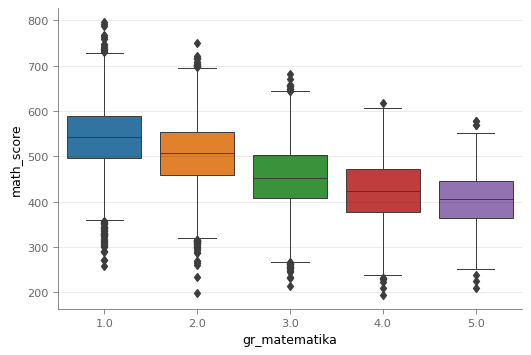

In [123]:
sns.boxplot(x='gr_matematika', y='math_score', data=dfl)

In [127]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['W_FSTUWT'].sum().reset_index()

In [129]:
foo.head()

,gr_matematika,SCH_BIN,ST225Q06HA,W_FSTUWT
0,1.0,0,0.0,236.38673
1,1.0,0,1.0,531.95663
2,1.0,1,0.0,142.04417
3,1.0,1,1.0,1004.17629
4,1.0,2,0.0,108.02849


In [135]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_matematika', 'SCH_BIN'])[['ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()

<AxesSubplot:xlabel='gr_matematika', ylabel='ST225Q06HA'>

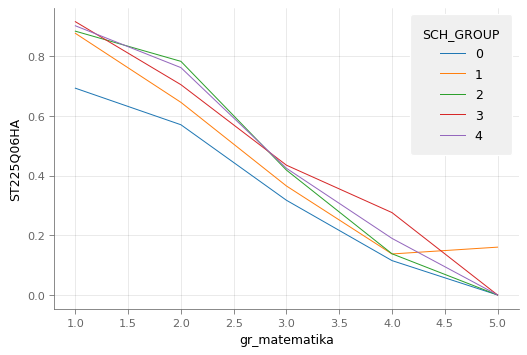

In [136]:
foo['SCH_GROUP'] = pd.Categorical(foo['SCH_BIN'])
sns.lineplot(x='gr_matematika', y='ST225Q06HA', data=foo, hue='SCH_GROUP')

<AxesSubplot:xlabel='gr_matematika', ylabel='BSMJ'>

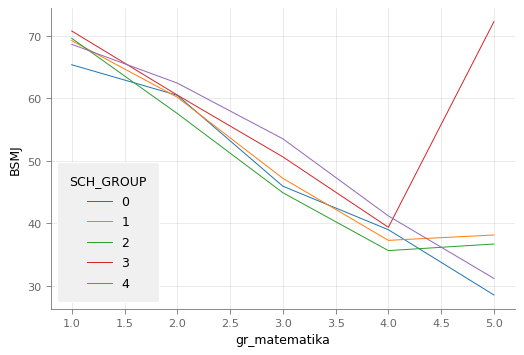

In [137]:
sns.lineplot(x='gr_matematika', y='BSMJ', data=foo, hue='SCH_GROUP')

<AxesSubplot:xlabel='gr_matematika', ylabel='Count'>

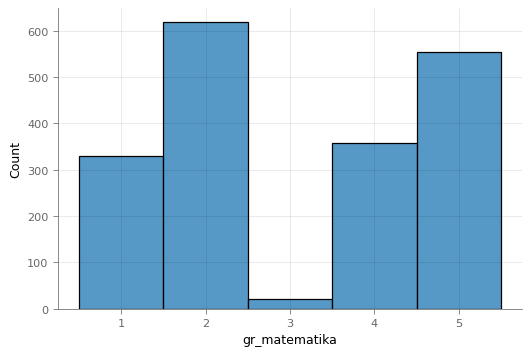

In [69]:
sns.histplot(x='gr_matematika', data=df, bins=[0.5 + i for i in range(0, 6)])

<AxesSubplot:xlabel='ST800C01HA_CZ', ylabel='Count'>

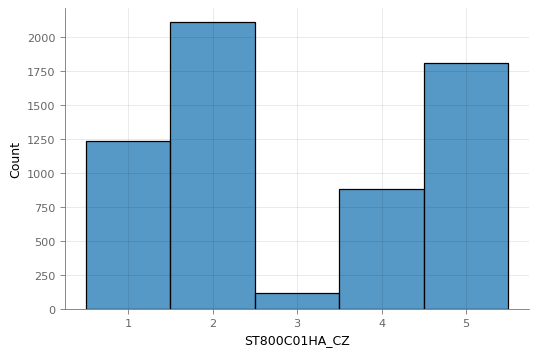

In [70]:
sns.histplot(x='ST800C01HA_CZ', data=stu18, bins=[0.5 + i for i in range(0, 6)])

<AxesSubplot:xlabel='ST800C02HA_CZ', ylabel='Count'>

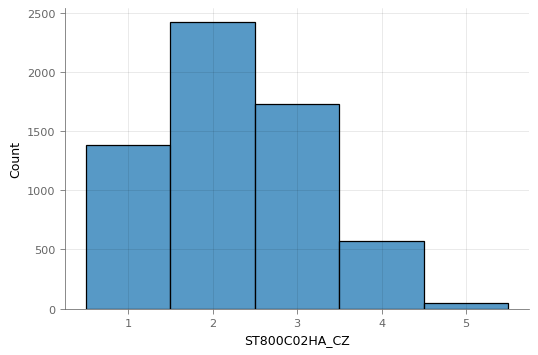

In [71]:
sns.histplot(x='ST800C02HA_CZ', data=stu18, bins=[0.5 + i for i in range(0, 6)])

<AxesSubplot:xlabel='ST800C03HA_CZ', ylabel='Count'>

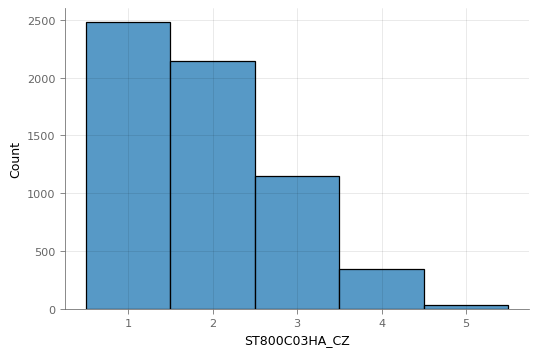

In [72]:
sns.histplot(x='ST800C03HA_CZ', data=stu18, bins=[0.5 + i for i in range(0, 6)])

In [ ]:
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)

In [74]:
stu18_meta.variable_value_labels['ST800C01HA_CZ']

{1.0: '1',
 2.0: '2',
 3.0: '3',
 4.0: '4',
 5.0: '5',
 6.0: 'I don´t study this subject',
 95.0: 'Valid Skip',
 97.0: 'Not Applicable',
 98.0: 'Invalid',
 99.0: 'No Response'}

In [75]:
stu18['MATH_MEAN'] = np.mean(stu18[[f'PV{i}MATH' for i in range(1,11)]], axis=1)

In [79]:
stu18['READ_MEAN'] = np.mean(stu18[[f'PV{i}READ' for i in range(1,11)]], axis=1)

<AxesSubplot:xlabel='ST800C01HA_CZ', ylabel='MATH_MEAN'>

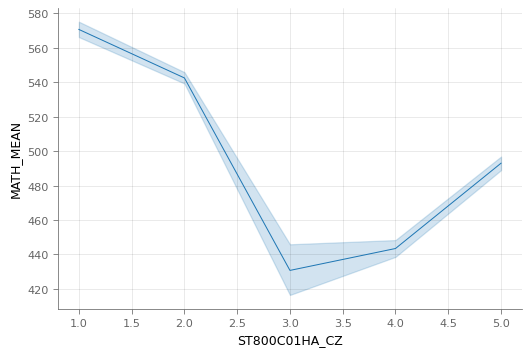

In [78]:
sns.lineplot(x='ST800C01HA_CZ', y='MATH_MEAN', data=stu18[stu18['ST800C01HA_CZ'] <= 5])

<AxesSubplot:xlabel='ST800C02HA_CZ', ylabel='READ_MEAN'>

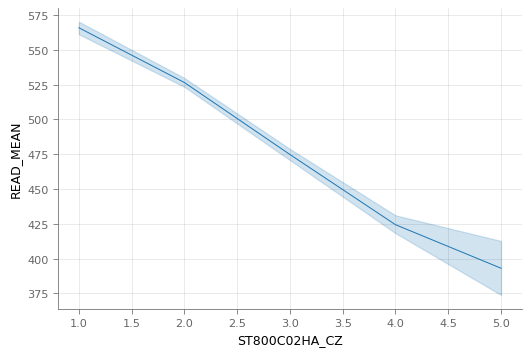

In [81]:
sns.lineplot(x='ST800C02HA_CZ', y='READ_MEAN', data=stu18[stu18['ST800C02HA_CZ'] <= 5])

In [84]:
stu18['MATH_GRADE_HACK'] = np.where(stu18['ST800C01HA_CZ'] < 3, stu18['ST800C01HA_CZ'], np.where(stu18['ST800C01HA_CZ'] < 6, 8 - stu18['ST800C01HA_CZ'], np.nan))

<AxesSubplot:xlabel='MATH_GRADE_HACK', ylabel='MATH_MEAN'>

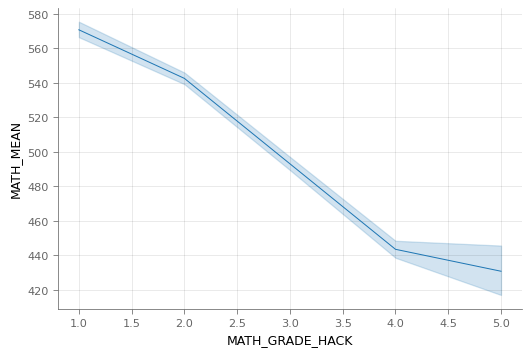

In [85]:
sns.lineplot(x='MATH_GRADE_HACK', y='MATH_MEAN', data=stu18)

<AxesSubplot:xlabel='MATH_GRADE_HACK', ylabel='Count'>

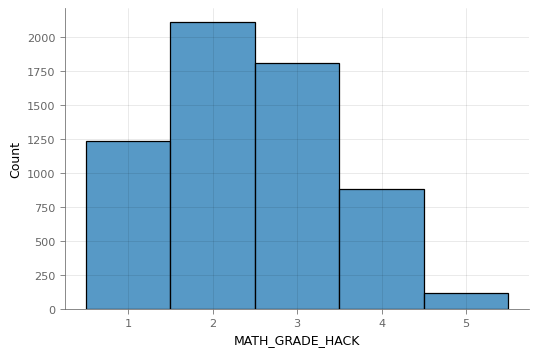

In [86]:
sns.histplot(x='MATH_GRADE_HACK', data=stu18, bins=[0.5 + i for i in range(0, 6)])

In [11]:
np.isfinite(stu18['ST800C01HA_CZ'])

0       True
1       True
2       True
3       True
4       True
        ... 
7014    True
7015    True
7016    True
7017    True
7018    True
Name: ST800C01HA_CZ, Length: 7019, dtype: bool

In [4]:
sch18_vars = sch18[['CNTSCHID', 'SC013Q01TA', 'SCHSIZE']].copy()
sch18_vars['sch_public'] = np.where(sch18_vars['SC013Q01TA'].isnull(), pd.NA, sch18_vars['SC013Q01TA'] == 1)
sch18_vars['sch_pupils'] = sch18_vars['SCHSIZE']
sch18_vars = sch18_vars.drop(columns=['SC013Q01TA', 'SCHSIZE'])